In [1]:
import pandas as pd
import numpy as np

from prophet import Prophet
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
from sqlalchemy import event
from sqlalchemy import text
import os
from dotenv import load_dotenv
import sys
import warnings

In [2]:
sys.path.append(os.path.abspath('..'))
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
from src.database_tool.connect_db import ConnectDB

In [4]:
db = ConnectDB()
engine = db.get_engine()

DB_USER and DB_PASSWORD are set


In [5]:
tables = db.show_tables()

In [6]:
tables

,Tables
0,capital_structure_debt
1,capital_structure_equity
2,capital_structure_summary
3,company_news
4,financial_metrics
5,financial_ratios
6,fundamentals_annual
7,fundamentals_quarterly
8,identifiers
9,insider_trade


In [7]:
stocks_table = db.read_table('security_daily')

In [8]:
stocks_table.sample(3)

,ticker,datadate,prccd,prchd,prcld,prcod,trfd
4169,NVDA,2024-05-01,830.41,860.00,812.5456,850.77,1.090000
4715,INTC,2024-03-20,42.20,43.01,41.4100,42.99,1.774572
361,ADBE,2025-02-19,456.99,463.61,455.3200,463.61,1.096237


In [9]:
stocks_table[stocks_table['ticker'] == 'AAPL'][['datadate', 'prccd']]

,datadate,prccd
13,2025-03-18,212.69
21,2025-03-17,214.00
52,2025-03-14,213.49
75,2025-03-13,209.68
84,2025-03-12,216.98
...,...,...
5668,2024-01-08,185.56
5689,2024-01-05,181.18
5703,2024-01-04,181.91
5726,2024-01-03,184.25


In [10]:
data = stocks_table[stocks_table['ticker'] == 'AAPL'][['datadate', 'prccd']]

In [11]:
data.rename(columns={'datadate': 'ds', 'prccd': 'y'}, inplace=True)

In [12]:
earnings_dates = pd.DataFrame({
    'holiday': 'earnings_release',
    'ds': pd.to_datetime(['2024-01-31', '2024-04-30', '2024-07-30', '2024-10-31']), 
    'lower_window': 0,
    'upper_window': 1
})

In [13]:
model = Prophet(
    changepoint_prior_scale=0.15,
    seasonality_prior_scale=15,
    uncertainty_samples=2000,
    holidays=earnings_dates
)

In [14]:
model.add_seasonality(name='weekly', period=7, fourier_order=3)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

In [15]:
data['y'] = np.log(data['y']) 

In [16]:
model.fit(data)

14:24:36 - cmdstanpy - INFO - Chain [1] start processing


14:24:36 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
future = model.make_future_dataframe(periods=30)

In [18]:
forecast = model.predict(future)

In [19]:
forecast['yhat'] = np.exp(forecast['yhat'])
forecast['yhat_lower'] = np.exp(forecast['yhat_lower'])
forecast['yhat_upper'] = np.exp(forecast['yhat_upper'])

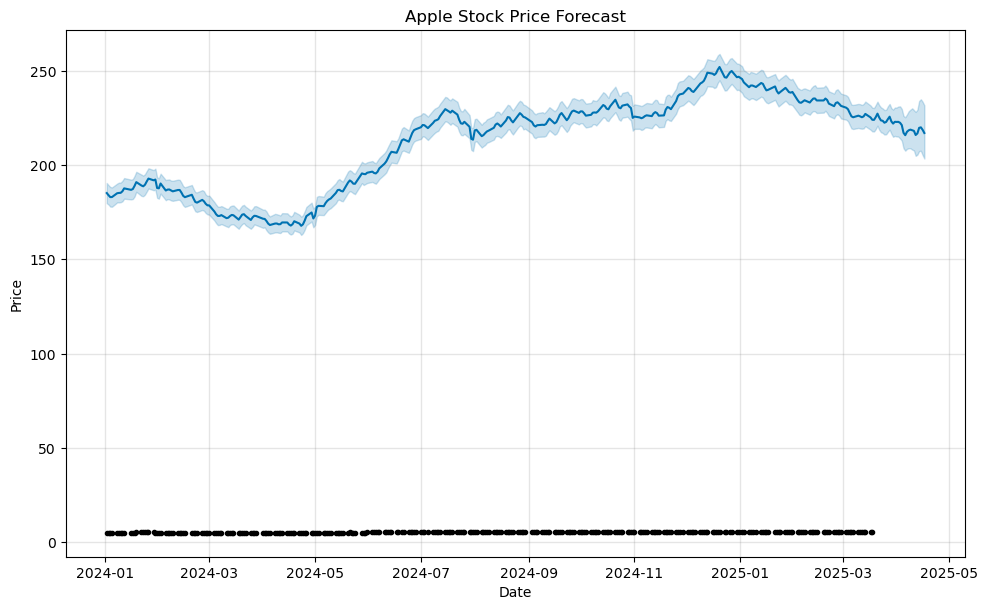

In [20]:
fig = model.plot(forecast)
plt.title("Apple Stock Price Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [21]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

,ds,yhat,yhat_lower,yhat_upper
303,2025-03-19,223.960343,217.801989,230.230945
304,2025-03-20,225.411138,219.075542,231.835649
305,2025-03-21,227.258458,220.874447,233.616870
306,2025-03-22,225.204043,218.721569,231.763563
307,2025-03-23,223.670409,217.414279,230.595707
308,2025-03-24,223.475750,217.035159,230.011265
309,2025-03-25,222.460909,216.178027,229.149347
310,2025-03-26,222.883170,216.307963,229.317993
311,2025-03-27,224.351310,217.613385,231.140752
312,2025-03-28,225.639687,218.778552,232.397656
